In [2]:
%pip install numpy pandas matplotlib statsmodels


[notice] A new release of pip available: 22.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# Interactive widget
from ipywidgets import interact


# Retina mode
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [4]:
file_path = 'co2_mm_mlo.csv'
names = 'year,month,decimal date,average,deseasonalized,ndays,sdev,unc'.split(',')

# no index
df = pd.read_csv(file_path, skiprows=41, names=names, index_col=False)

In [5]:
df.index = pd.to_datetime(df[['year', 'month']].apply(lambda x: '{}-{}'.format(x[0], x[1]), axis=1))

In [6]:
# Create X and y

# X = months since first measurement

X = np.array(range(len(df)))
y = df.average.values

In [7]:
# Spliting the data into train and test, 80:20 split
y = y.flatten().tolist()  # This is correct if y is a NumPy array
split_index = int(0.8 * len(y))

train_data = y[:split_index]
X_train_data = X[:split_index]
test_data = y[split_index:]
X_test_data = X[split_index:]

Text(0, 0.5, 'CO2 Level')

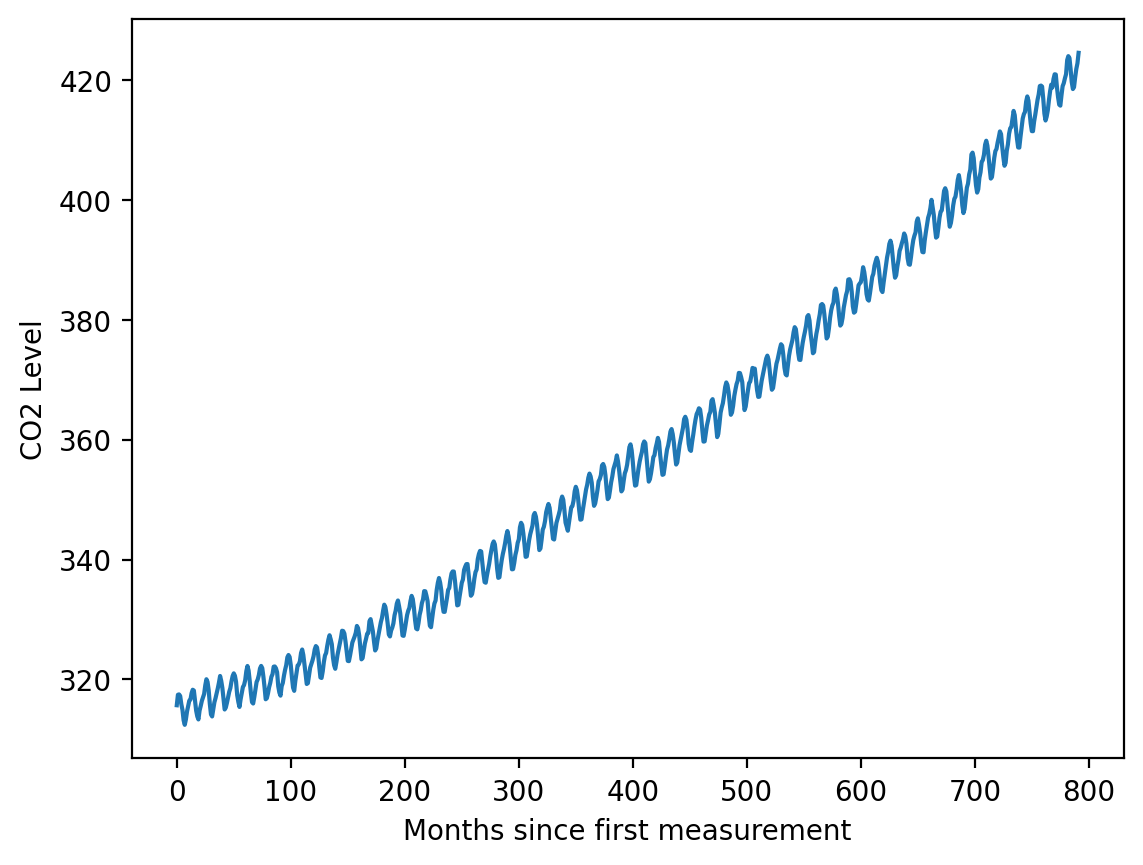

In [8]:
plt.plot(X, y)
plt.xlabel('Months since first measurement')
plt.ylabel('CO2 Level')

Moving Average

Mean Squared Error (MSE) for Moving Average: 7.025762099739875


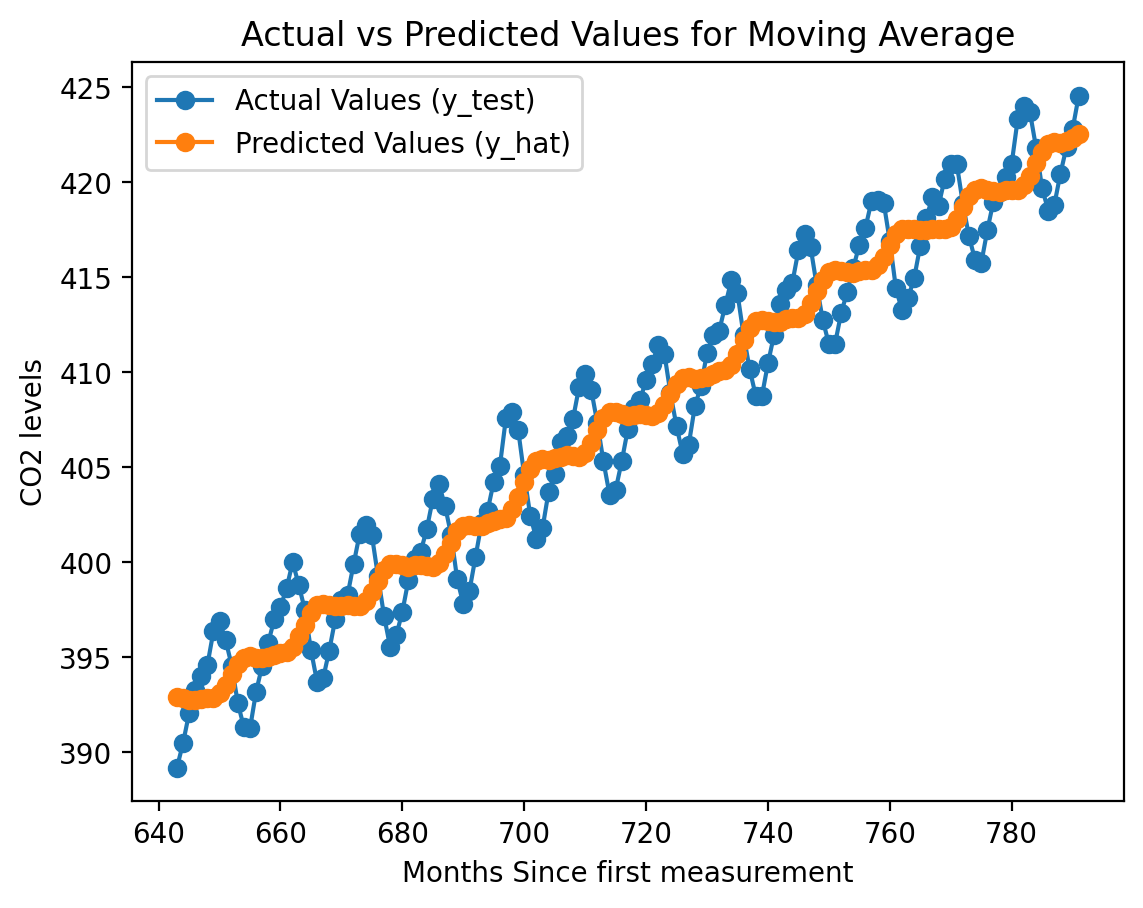

In [9]:
def make_dataset_ma(y, X, lag):
    X_train = []
    y_train = []
    months = []
    for i in range(len(y)-lag):
        row = y[i:i+lag]
        y_train.append(y[i+lag])
        X_train.append(pd.Series(row).mean())  # Calculate moving average
        month_value = X[i+lag]
        months.append(month_value)

    X_train = pd.Series(X_train)
    y_train = pd.Series(y_train)
    return X_train, y_train, months


# Example run of the model using a lag of 10 for moving average
lag = 10
X_train_ma, y_train_ma, months_train_ma = make_dataset_ma(train_data, X_train_data, lag)
reg_ma = LinearRegression().fit(X_train_ma.values.reshape(-1, 1), y_train_ma)
X_test_ma, y_test_ma, months_test_ma = make_dataset_ma(test_data, X_test_data, lag)
y_hat_ma = reg_ma.predict(X_test_ma.values.reshape(-1, 1))
mse_ma = mean_squared_error(y_test_ma, y_hat_ma)

print(f"Mean Squared Error (MSE) for Moving Average: {mse_ma}")
# Plotting the predicted output for lag=10 for the test sequence
plt.plot(months_test_ma, y_test_ma, label='Actual Values (y_test)', marker='o')
plt.plot(months_test_ma, y_hat_ma, label='Predicted Values (y_hat)', marker='o')
plt.xlabel('Months Since first measurement')
plt.ylabel('CO2 levels')
plt.title('Actual vs Predicted Values for Moving Average')
plt.legend()
plt.show()


ARMA

c:\Users\madha\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Mean Squared Error (MSE) for ARMA(6,1): 41.633183961371614


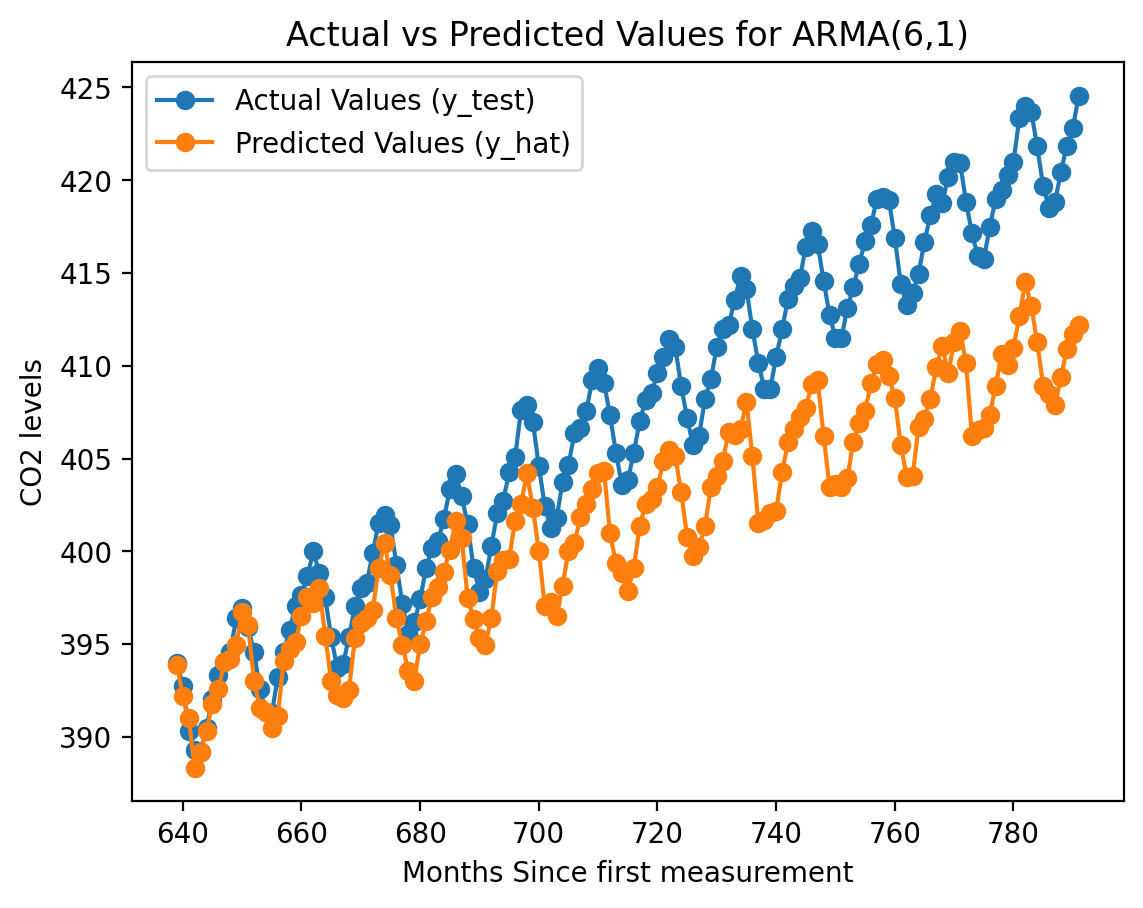

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Define a function to create dataset for ARMA model
def make_dataset_arma(y, X, p, q):
    X_train = []
    y_train = []
    months_train = []

    for i in range(max(p, q), len(y)):
        y_train.append(y[i])
        X_train.append(y[i-p:i] + X[i-q:i])  # Combine AR and MA terms
        months_train.append(X[i])

    return np.array(X_train), np.array(y_train), np.array(months_train)

# Example run of the model using ARMA(2, 1)
p = 6  # AR order
q = 1  # MA order

X_train_arma, y_train_arma, months_train_arma = make_dataset_arma(train_data, X_train_data, p, q)
X_test_arma, y_test_arma, months_test_arma = make_dataset_arma(test_data, X_test_data, p, q)

# Fit the ARMA model
model_arma = ARIMA(y_train_arma, order=(p, 0, q), exog=X_train_arma)
result_arma = model_arma.fit()

# Forecast
y_hat_arma = result_arma.forecast(steps=len(X_test_arma), exog=X_test_arma)

# Calculate Mean Squared Error (MSE)
mse_arma = np.mean((y_test_arma - y_hat_arma)**2)
print(f"Mean Squared Error (MSE) for ARMA({p},{q}): {mse_arma}")

# Plotting the predicted output for ARMA model
plt.plot(months_test_arma, y_test_arma, label='Actual Values (y_test)', marker='o')
plt.plot(months_test_arma, y_hat_arma, label='Predicted Values (y_hat)', marker='o')
plt.xlabel('Months Since first measurement')
plt.ylabel('CO2 levels')
plt.title(f'Actual vs Predicted Values for ARMA({p},{q})')
plt.legend()
plt.show()


trying out ARMA by straightforward method

Mean Squared Error (MSE) for ARMA(6,1): 458.58229224657816


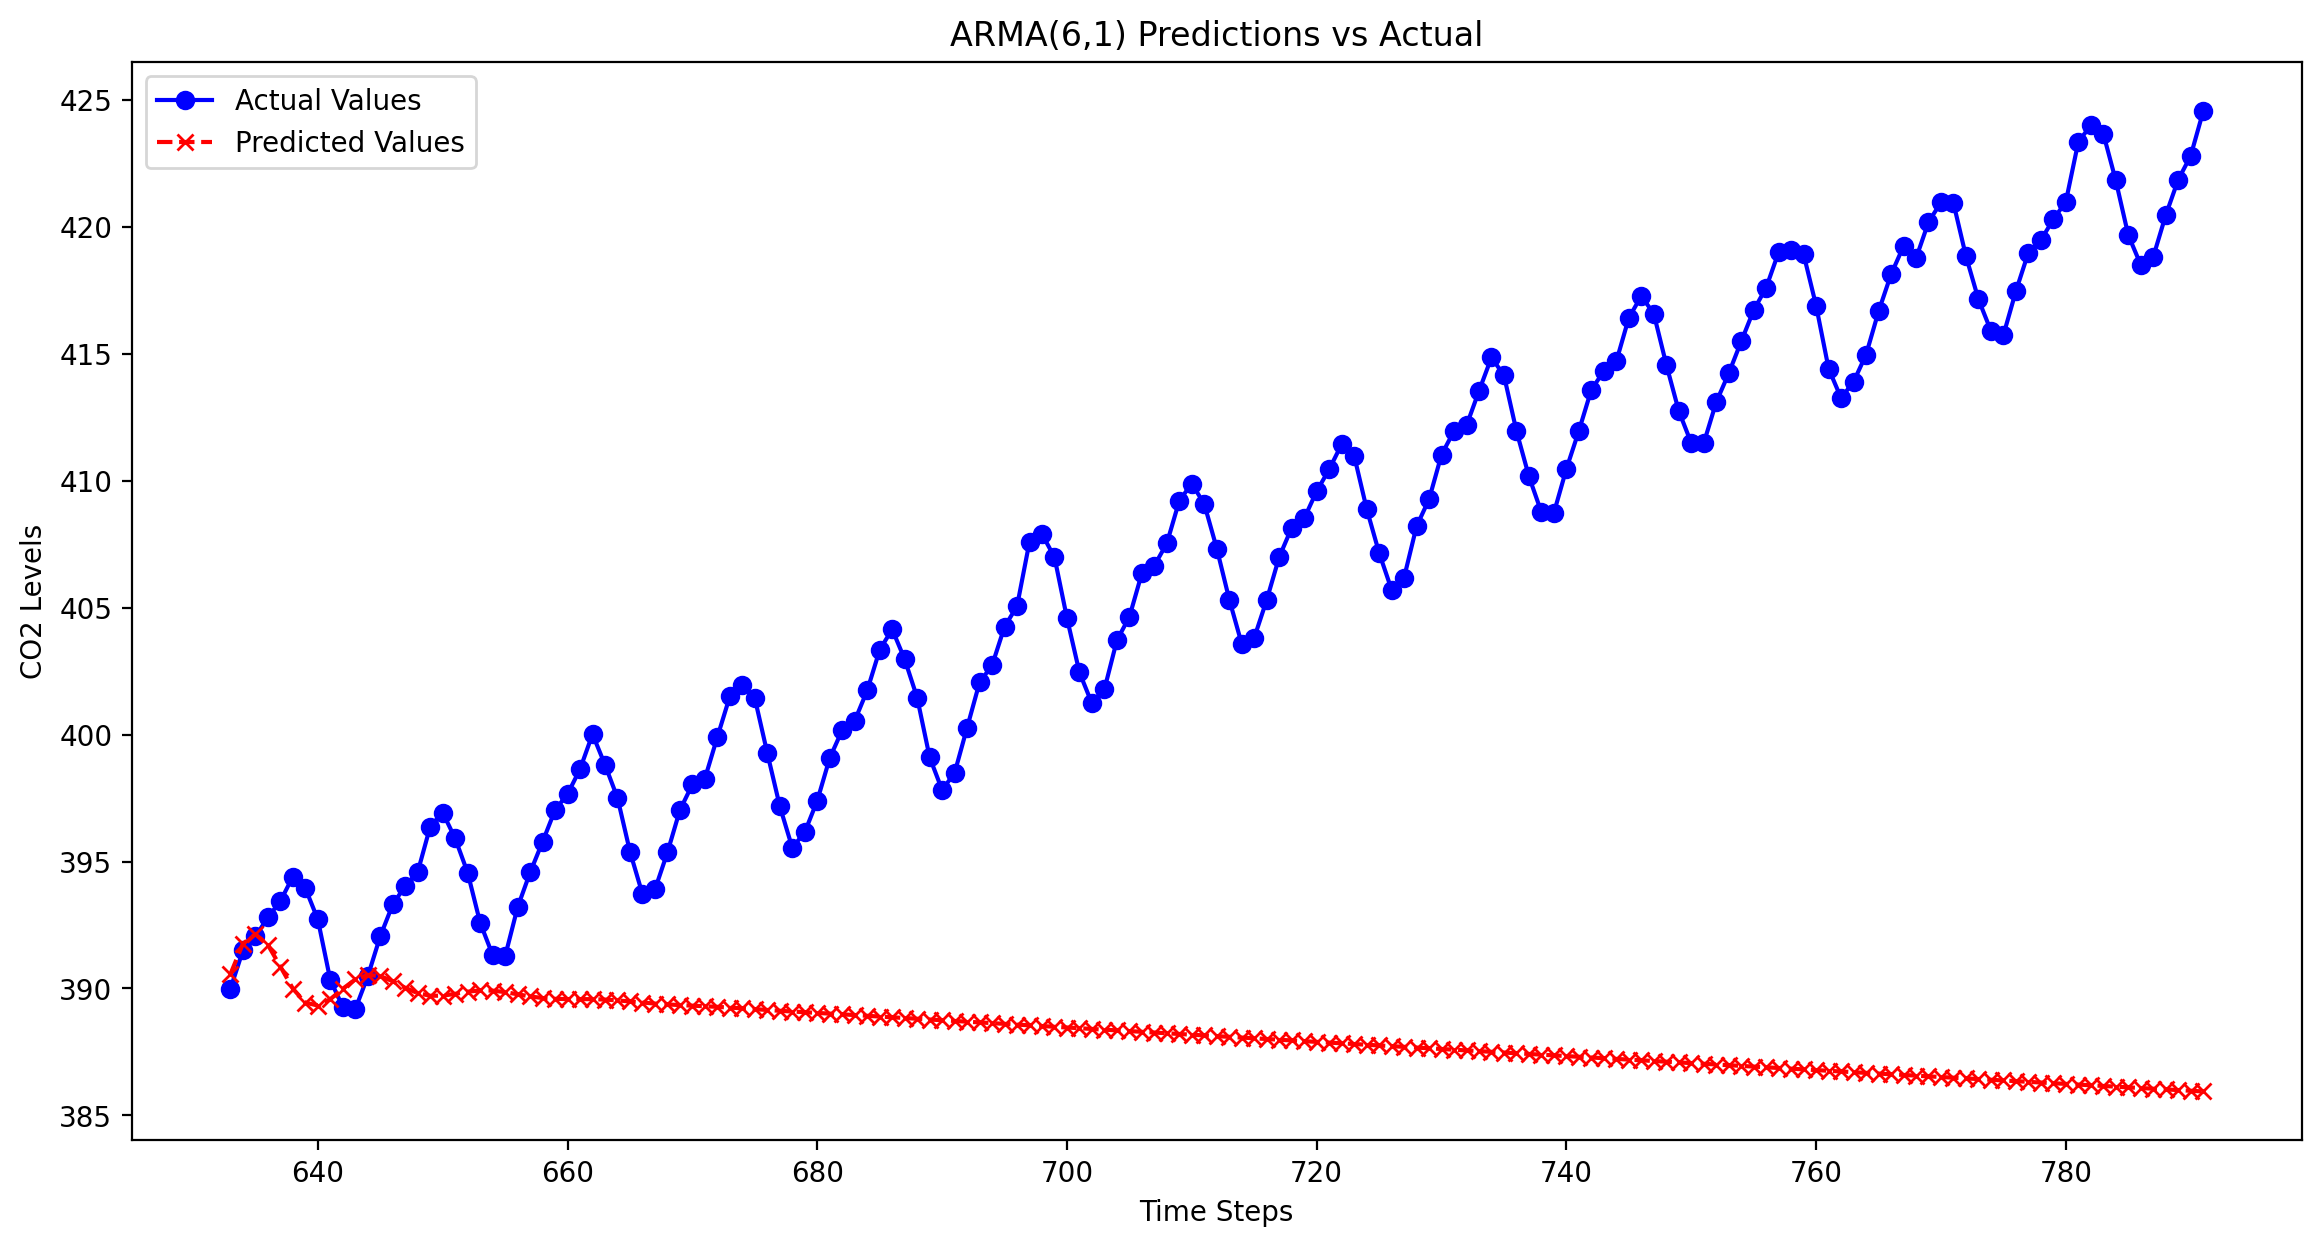

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

# Assuming 'train_data' and 'test_data' are defined as per your dataset

# Example ARMA configuration
p = 6  # AR order
q = 1  # MA order

# Fit the ARMA model to the training data
model_arma = ARIMA(train_data, order=(p, 0, q))
result_arma = model_arma.fit()

# Forecast the next values matching the test set size
y_hat_arma = result_arma.forecast(steps=len(test_data))

# Calculate Mean Squared Error (MSE)
mse_arma = np.mean((test_data - y_hat_arma)**2)
print(f"Mean Squared Error (MSE) for ARMA({p},{q}): {mse_arma}")

# Since 'test_data' does not have a specific date index, we create a placeholder index for plotting
test_index = np.arange(len(train_data), len(train_data) + len(test_data))

# Plotting the predicted output for ARMA model
plt.figure(figsize=(14, 7))
plt.plot(test_index, test_data, label='Actual Values', marker='o', color='blue')
plt.plot(test_index, y_hat_arma, label='Predicted Values', linestyle='--', marker='x', color='red')
plt.xlabel('Time Steps')
plt.ylabel('CO2 Levels')
plt.title(f'ARMA({p},{q}) Predictions vs Actual')
plt.legend()
plt.show()


MLP

In [12]:
def make_dataset(y, X, lag):
    X_train = []
    y_train = []
    months_train = []

    for i in range(len(y)-lag):
        row = y[i:i+lag]
        y_train.append(y[i+lag])
        X_train.append(row)

        month_value = X[i+lag]  # Assuming X contains month values
        months_train.append(month_value)

    X_train = pd.DataFrame(X_train)
    y_train = pd.Series(y_train)
    months_train = pd.Series(months_train)

    return X_train, y_train, months_train


Epoch [10/200], Loss: 168.27491760253906
Epoch [20/200], Loss: 2092.936279296875
Epoch [30/200], Loss: 2970.71875
Epoch [40/200], Loss: 664.1387939453125
Epoch [50/200], Loss: 48.899410247802734
Epoch [60/200], Loss: 13.017780303955078
Epoch [70/200], Loss: 21.818937301635742
Epoch [80/200], Loss: 17.402748107910156
Epoch [90/200], Loss: 11.55711555480957
Epoch [100/200], Loss: 8.512724876403809
Epoch [110/200], Loss: 7.234668731689453
Epoch [120/200], Loss: 6.755730628967285
Epoch [130/200], Loss: 6.588136672973633
Epoch [140/200], Loss: 6.53489351272583
Epoch [150/200], Loss: 6.520538330078125
Epoch [160/200], Loss: 6.517565727233887
Epoch [170/200], Loss: 6.516707897186279
Epoch [180/200], Loss: 6.5156707763671875
Epoch [190/200], Loss: 6.514347076416016
Epoch [200/200], Loss: 6.512984752655029
Mean Squared Error (MSE): 7.512960949961393


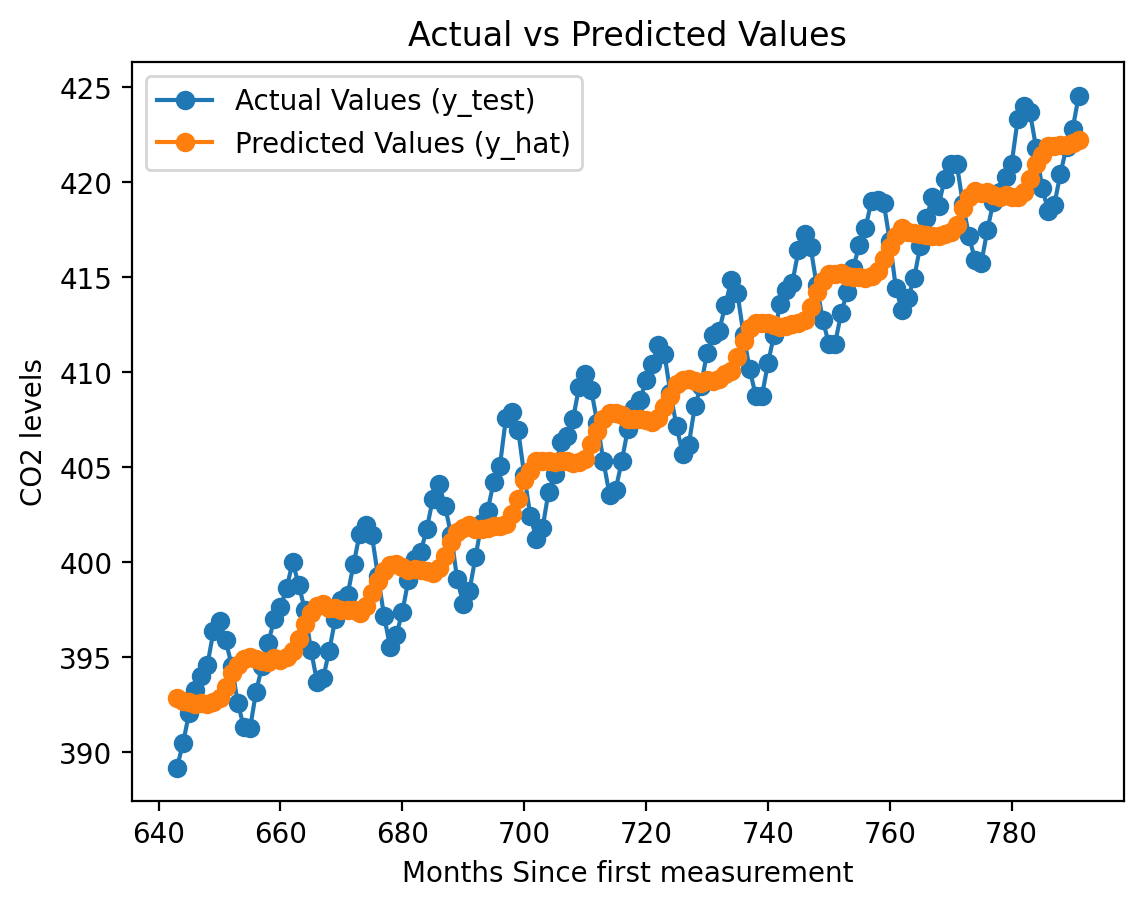

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

# Convert data to PyTorch tensors
def prepare_data(X, y):
    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    y_tensor = torch.tensor(y.values, dtype=torch.float32)
    return X_tensor, y_tensor

# Train the MLP model
def train_model(model, X_train, y_train, num_epochs=100, learning_rate=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs.squeeze(), y_train)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')

# Make predictions using the trained model
def predict(model, X_test):
    with torch.no_grad():
        return model(X_test).numpy()

# Example run of the MLP model
lag = 10
input_size = lag
hidden_size = 16  # You can adjust this according to your problem
output_size = 1

# Prepare data
X_train, y_train, _ = make_dataset(train_data, X_train_data, lag)
X_test, y_test, months_test = make_dataset(test_data, X_test_data, lag)
X_train_tensor, y_train_tensor = prepare_data(X_train, y_train)
X_test_tensor, y_test_tensor = prepare_data(X_test, y_test)

# Initialize and train the model
model = MLP(input_size, hidden_size, output_size)
train_model(model, X_train_tensor, y_train_tensor, num_epochs=200, learning_rate=0.01)

# Make predictions
y_hat = predict(model, X_test_tensor)

# Calculate MSE
mse = mean_squared_error(y_test, y_hat)
print(f"Mean Squared Error (MSE): {mse}")


# Plotting the predicted output for the test sequence
plt.plot(months_test, y_test, label='Actual Values (y_test)', marker='o')
plt.plot(months_test, y_hat, label='Predicted Values (y_hat)', marker='o')
plt.xlabel('Months Since first measurement')
plt.ylabel('CO2 levels')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()
